## Data Processing

In [2]:
import pandas as pd
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [367]:
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])

Calculate total number of nonwhite students and staff for weighted averages

In [368]:
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])
students['Nonwhite (Num Stu)'] = students["Total Students"] - (round(students['White']/100 * students['Total Students'], 0))
staff['Nonwhite (Num Staff)'] = staff["FTE Count"] - staff["White (# )"]

In [369]:
df = pd.merge(students, staff, how= "left", on= ['Org Code','Year'])
df = pd.merge(df, addresses, how= "inner", on = "Org Code")
df = df[["Org Code", "Org Name", "Org Type", "Year", "Job Category", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count", "Zip Code"]]

Remove state totals

In [370]:
df_mask = df["Org Code"] == 0
df = df[~df_mask]

## What is the breakdown of staff race/ethnicity within the following school employee roles in Massachusetts: principal, administrator, teacher, and support staff?

### What are the trends in student and staff populations over time?

We first plotted the percent of non-white staff and students over time. We found that the percent of nonwhite staff has remained flat over the past 6 years, hovering between 7.8 and 8.2%, while the percent of nonwhite students has increased by approximately 1% each year, from 30.3% of students in 2010 to 36.1% of students in 2015. 

In [121]:
year_grouped = df.groupby(["Year"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [122]:
year_grouped['Perc Nonwhite Students'] = year_grouped['Nonwhite (Num Stu)'] / year_grouped['Total Students'] * 100
year_grouped['Perc Nonwhite Staff'] = year_grouped['Nonwhite (Num Staff)'] / year_grouped['FTE Count'] * 100
year_grouped = year_grouped.reset_index()

,Year,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Perc Nonwhite Students,Perc Nonwhite Staff
0,2010,2476440.0,8163810,17104.2,218152.3,30.334366,7.840486
1,2011,2563443.0,8170020,17037.3,216760.7,31.376215,7.859958
2,2012,2687481.0,8237394,17652.0,220492.8,32.625379,8.005704
3,2013,2786157.0,8283888,18382.4,225406.6,33.633446,8.155218
4,2014,2904205.0,8354091,18157.4,229304.4,34.763866,7.918470
5,2015,3047931.0,8445987,19252.7,235502.0,36.087328,8.175175


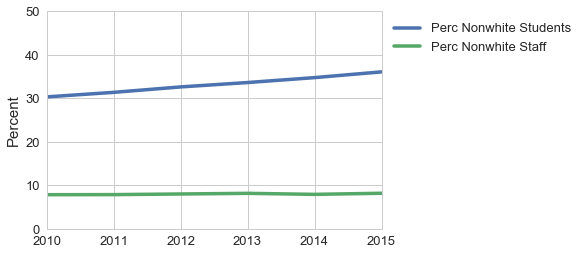

In [109]:
sns.set_style("whitegrid")
ax = year_grouped[['Year', 'Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot(linewidth=3.5)
ax.set_ylim(ymin = 0, ymax = 50)
ax.set_ylabel('Percent', fontsize=15)
ax.set_xlabel("")
ax.tick_params(labelsize=13)
ax.legend(bbox_to_anchor=(1.6,1), loc="upper right", prop={'size': 13});

Since fewer than 10% of staff members in Massachusetts schools are nonwhite, we decided not to differentiate between different nonwhite ethnic and racial groups in our analysis.

### What is the breakdown of nonwhite staff members within different school roles in Massachusetts?

We explored the average percent of nonwhite staff in every job category from 2010 to 2015. Although nonwhite staff members have comprised 8% of school staff employees on average, a higher percentage of nonwhite employees are Paraprofessionals (11.7%) or Administrative Support (9.5%) than Teachers (6.8%). Encouragingly, 10.8% of school leaders report as nonwhite. We wanted to explore this as a potential contributing factor to schools that have higher percentages of nonwhite staff, as Massachusetts school leaders are generally the decision makers for hiring and school culture. 

In [29]:
df_jobs_grouped = df.groupby("Job Category").sum()[["Nonwhite (Num Staff)", "FTE Count"]]
df_jobs_grouped["% Nonwhite Staff"] = round(df_jobs_grouped["Nonwhite (Num Staff)"] / df_jobs_grouped["FTE Count"] * 100, 1)
df_jobs_grouped.reset_index()

,Job Category,Nonwhite (Num Staff),FTE Count,% Nonwhite Staff
0,Administrative Support,3193.9,33462.1,9.5
1,All Staff,53788.7,672689.1,8.0
2,District Leaders,154.4,2115.9,7.3
3,Health,507.6,10840.0,4.7
4,Paraprofessionals,15512.2,132788.5,11.7
5,Related Service Providers,678.8,19189.8,3.5
6,School Leaders,2716.3,25111.6,10.8
7,Student Support,3058.4,37248.8,8.2
8,Teachers,27975.7,412173.0,6.8


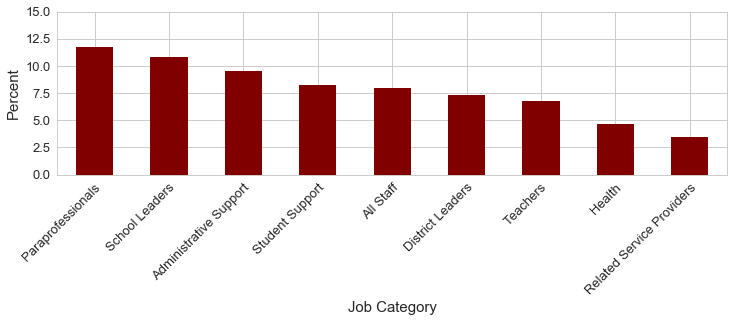

In [108]:
sns.set_style("whitegrid")
job = df_jobs_grouped["% Nonwhite Staff"].sort_values(ascending = False).plot(kind = "bar", color = "maroon", figsize = (12, 3))
job.set_ylim(ymin = 0, ymax = 15)
job.set_ylabel('Percent', fontsize=15)
job.tick_params(labelsize=13)
job.set_xlabel("Job Category", fontsize = 15)
job.set_xticklabels(job.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor');

## In which schools are we most likely to find nonwhite staff members in Massachusetts?

### Is there a correlation between the percent of nonwhite students and percent of nonwhite staff in schools?

One of our hypotheses is that schools with higher percentages of nonwhite students will also have higher percentages of nonwhite staff. We looked at the correlation between percent of nonwhite students and percents of nonwhite staff for each year between 2010 and 2015:

In [204]:
df.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Zip Code
0,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,All Staff,913.0,1426,3.0,145.7,01606
1,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,District Leaders,913.0,1426,0.0,2.0,01606
2,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,School Leaders,913.0,1426,0.0,7.8,01606
3,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,Teachers,913.0,1426,1.0,103.6,01606
4,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,Student Support,913.0,1426,1.0,5.5,01606


In [371]:
df['Perc Nonwhite Students'] = df['Nonwhite (Num Stu)'] / df['Total Students'] * 100
df['Perc Nonwhite Staff'] = df['Nonwhite (Num Staff)'] / df['FTE Count'] * 100

In [444]:
all_staff_mask = df["Job Category"] == "All Staff"
all_staff_mask &= df["FTE Count"] > 0
df_staff = df[all_staff_mask]

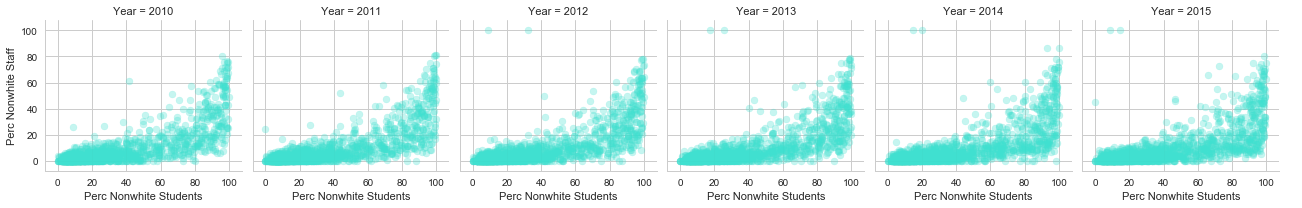

In [445]:
sns.set_style("whitegrid")
g = sns.FacetGrid(df_staff, col="Year")
g = (g.map(plt.scatter, "Perc Nonwhite Students", "Perc Nonwhite Staff", color = "turquoise", alpha = 0.3).add_legend())

The correlations by year are very similar, and we know that the percentage of nonwhite staff has not changed very much over time. For this reason, we continue our analysis with just the 2015 data. 

In [446]:
mask_15 = df_staff["Year"] == 2015
df_staff_15 = df_staff[mask_15]
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Zip Code,Perc Nonwhite Students,Perc Nonwhite Staff
45,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2015,All Staff,1071.0,1428,7.6,163.6,01606,75.000000,4.645477
99,10505,Abington: Abington High,Public School,2015,All Staff,55.0,477,3.0,59.5,02351,11.530398,5.042017
153,10405,Abington: Abington Middle School,Public School,2015,All Staff,28.0,305,1.0,37.0,02351,9.180328,2.702703
207,10015,Abington: Woodsdale Elementary School,Public School,2015,All Staff,26.0,330,1.0,32.1,02351,7.878788,3.115265
261,4120530,Academy Of the Pacific Rim Charter Public (Dis...,Charter School,2015,All Staff,437.0,519,10.0,55.5,02136,84.200385,18.018018


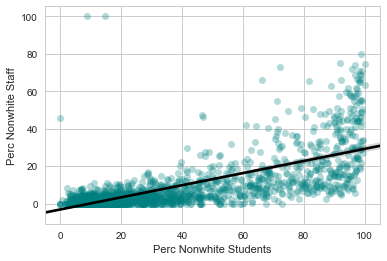

In [447]:
sns.set_style("whitegrid", rc={'axes.linewidth': 1})
sns.regplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_staff_15, scatter_kws = {"color": "teal", "alpha" : 0.3,}, line_kws = {"color": "black"});

Before running our regression, we looked at a few other factors that we believed would have an impact on the percent of nonwhite staff in a school.

### Nonwhite school leaders

To look at the relationship between the percent of nonwhite staff and the presence of a nonwhite school leader, we used a mask to make a school leader True/False indicator in our data frame. 

First, we looked at the percent of non-white staff as a function of non-white leaders. On a side-by-side bar comparison it is visible that hiring decisions are correlated with school non-white leaders and higher non-white student population. [Box and whisker] 

In [448]:
sl_mask = df["Year"] == 2015
sl_mask &= df["Job Category"] == "School Leaders"
school_leaders = df[sl_mask]

In [449]:
school_leaders["Nonwhite Leader"] = school_leaders['Perc Nonwhite Staff'] > 0.0

C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [450]:
school_leaders = school_leaders[["Org Code","Nonwhite Leader"]].set_index("Org Code")
df_staff_15 = df_staff_15.set_index("Org Code")
df_staff_15 = df_staff_15.join(school_leaders)

Schools with a nonwhite leader had a higher median percent of nonwhite staff, but there were many outliers for schools without a nonwhite leader. 

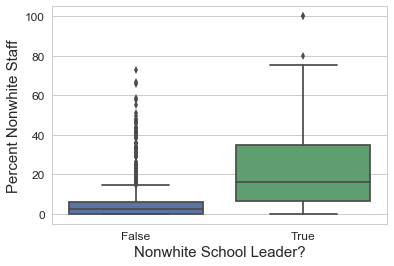

In [451]:
sl = sns.boxplot(x="Nonwhite Leader", y="Perc Nonwhite Staff", data=df_staff_15)
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("Nonwhite School Leader?", fontsize = 15);

When we updated our scatterplot to show schools with and without a nonwhite leader, the trend line for schools with a nonwhite leader had a steeper slope than schools with all white leaders. This was especially pronounced in schools with higher percentages of nonwhite students. 

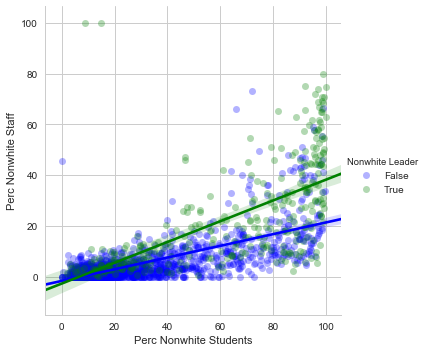

In [452]:
sc = sns.lmplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_staff_15, hue="Nonwhite Leader", palette = ["blue", "green"], scatter_kws = {"alpha" : 0.3,})

### Public versus charter schools

We looked at school type as a contributor to the percentage of nonwhite staff in schools next, because many Massachusetts charter schools serve nonwhite students. In a box-and-whisker plot, we saw that charter schools have a higher median percent of nonwhite staff. However, it is not possible to tell whether this is due to the school type or factors such as the location of the school. 

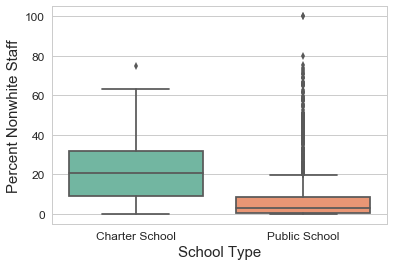

In [453]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=df_staff_15, palette="Set2")
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

### American Community Survey Data

Before running our regression, we wanted to bring a few ACS variables into our data frame: median income, percent of households with an 18-year-old child or younger in poverty, percent of high school graduates, percent of college graduates, and percent nonwhite residents by zip code. Our ACS check-out file is located HERE.

In [454]:
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates", "Zip Perc White"])

In [455]:
acs = acs.replace('-', np.NaN)
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')
acs["Percent Nonwhite Residents"] = 100 - acs["Zip Perc White"]

In [456]:
acs = acs.set_index("Zip Code")
acs.head()

,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,
01001,60161.0,7.1,91.5,28.0,91.8,8.2
01002,50540.0,14.7,95.6,68.0,78.4,21.6
01005,68786.0,2.6,95.7,24.0,97.3,2.7
01007,76881.0,8.5,92.4,42.0,94.9,5.1
01010,87961.0,0.0,94.0,41.6,100.0,0.0


In [457]:
df_staff_15 = df_staff_15.reset_index().set_index("Zip Code")
df_staff_15 = df_staff_15.join(acs)
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Perc Nonwhite Students,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,,,,,,,,,,,,,
01001,50003,Agawam: Agawam Early Childhood Center,Public School,2015,All Staff,11.0,165,2.0,43.5,6.666667,4.597701,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50505,Agawam: Agawam High,Public School,2015,All Staff,141.0,1280,1.1,138.2,11.015625,0.795948,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50303,Agawam: Roberta G. Doering School,Public School,2015,All Staff,78.0,590,3.2,80.5,13.220339,3.975155,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50020,Agawam: Benjamin J Phelps,Public School,2015,All Staff,54.0,406,0.2,52.1,13.300493,0.383877,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50030,Agawam: James Clark School,Public School,2015,All Staff,50.0,332,0.1,54.2,15.060241,0.184502,False,60161.0,7.1,91.5,28.0,91.8,8.2


In [458]:
df_staff_15 = df_staff_15.reset_index()

### 'In Boston' Indicator

Massachusetts is fairly segregated, particularly in the suburbs, so we believe that the location of a school could have an impact on its percentage of nonwhite staff. We included zip code as a categorical variable the first time we ran our regression, but including the 428 distinct zip codes seemed excessive. When examining the residuals, we noticed that the zip codes with the highest coefficients were those in Boston, so we created an 'In Boston' indicator for our model.

In [459]:
boston_zip = ['02111', '02113', '02115', '02116', '02118', '02119', '02120', '02121', '02122', '02124', '02125', '02126', '02127',
'02128', '02129', '02130', '02131', '02132', '02134', '02135', '02136', '02215']

boston_flag = ["Boston" for x in boston_zip]

boston = pd.DataFrame({'Zip Code': boston_zip, 'In Boston': boston_flag})

In [460]:
df_staff_15 = pd.merge(df_staff_15, boston, how = "left", on = "Zip Code")

In [461]:
df_staff_15["In Boston"] = df_staff_15["In Boston"].fillna("Not Boston")

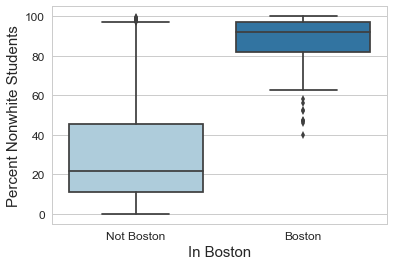

In [462]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Students", data=df_staff_15, palette="Paired")
boston.set_ylabel('Percent Nonwhite Students', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_xlabel("In Boston", fontsize = 15);

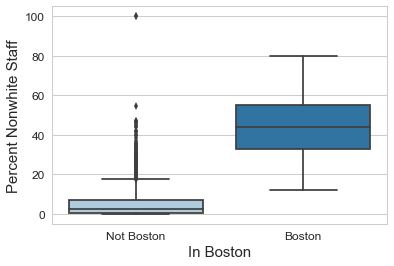

In [463]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Staff", data=df_staff_15, palette="Paired")
boston.set_ylabel('Percent Nonwhite Staff', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_xlabel("In Boston", fontsize = 15);

### Regression

In [464]:
df_staff_15 = df_staff_15.dropna(subset = ['Percent Poverty', '% HS Graduates', 'Percent Nonwhite Residents'])

The results show that several variables have a significant effect: percent of high graduates, non-white students, non-white school leader and total number of students, In Boston indicator. In Boston Indicator and Non-White school had the highest effects. 

In [476]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + perc_pov + hs_grad + total_stu + zip_nonwhite",
              data = df_staff_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     666.1
Date:                Wed, 29 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:33:27   Log-Likelihood:                -5991.2
No. Observations:                1797   AIC:                         1.200e+04
Df Residuals:                    1788   BIC:                         1.205e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    16.6368      3.837      4.336      0.000       9.111      24.162
nw_sl[T.True]                 5.5088      0.493     11.170      0.000       4.542       6.476
org_type[T.Public School]    -1.1384      0.842     -1.352      0.177      -2.790       0.513
in_boston[T.Not Boston]     -25.0702      0.755    -33.194      0.000     -26.551     -23.589
nw_stu                        0.1395      0.012     11.770      0.000       0.116       0.163
perc_pov                      0.0615      0.026      2.392      0.017       0.011       0.112
hs_grad                       0.0973      0.036      2.740      0.006       0.028       0.167
total_stu                    -0.0018      0.000     -3.750      0.000      -0.003      -0.001
zip_nonwhite                  0.0737      0.018      4.087      0.000       0.038       0.109
==============================================================================
Omnibus:                     1502.878   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           130312.316
Skew:                           3.378   Prob(JB):                         0.00
Kurtosis:                      44.167   Cond. No.                     1.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

8) We looked at the residuals, and saw that they become more spread out once schools have >50% nonwhite students. We reran our regression to see if the same variable contribute to the percentage of nonwhite staff. 

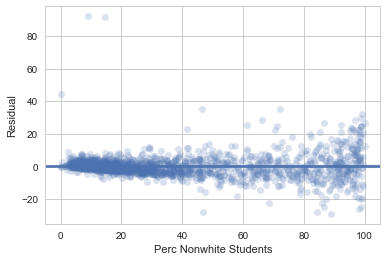

In [469]:
re = sns.regplot(x = df_staff_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

In [472]:
overhalf_mask = df_staff_15["Perc Nonwhite Students"] > 50.0
df_overhalf = df_staff_15[overhalf_mask]

In [481]:
## College grad becomes significant
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = df_overhalf.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     178.8
Date:                Wed, 29 Nov 2017   Prob (F-statistic):          1.15e-130
Time:                        22:34:41   Log-Likelihood:                -1827.8
No. Observations:                 499   AIC:                             3672.
Df Residuals:                     491   BIC:                             3705.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1377      4.264      0.032      0.974      -8.241       8.516
nw_sl[T.True]                 5.3816      0.978      5.502      0.000       3.460       7.303
org_type[T.Public School]     1.5956      1.557      1.025      0.306      -1.463       4.655
in_boston[T.Not Boston]     -20.9858      1.265    -16.593      0.000     -23.471     -18.501
nw_stu                        0.3105      0.038      8.170      0.000       0.236       0.385
college_grad                  0.1737      0.029      5.971      0.000       0.117       0.231
total_stu                    -0.0027      0.001     -2.492      0.013      -0.005      -0.001
zip_nonwhite                  0.1315      0.031      4.244      0.000       0.071       0.192
==============================================================================
Omnibus:                       22.914   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.184
Skew:                           0.409   Prob(JB):                     2.79e-07
Kurtosis:                       3.884   Cond. No.                     6.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

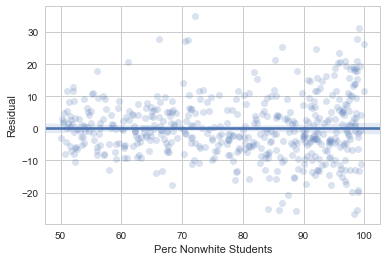

In [482]:
re = sns.regplot(x = df_overhalf["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

In [483]:
boston_mask = df_staff_15["In Boston"] == "Boston"
boston_15 = df_staff_15[boston_mask]

In [490]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = boston_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     21.04
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.87e-17
Time:                        22:40:10   Log-Likelihood:                -520.51
No. Observations:                 137   AIC:                             1055.
Df Residuals:                     130   BIC:                             1075.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -38.9830      8.844     -4.408      0.000     -56.480     -21.486
nw_sl[T.True]                 5.3084      2.233      2.377      0.019       0.890       9.727
org_type[T.Public School]    16.1356      2.723      5.926      0.000      10.749      21.522
nw_stu                        0.4013      0.080      5.013      0.000       0.243       0.560
college_grad                  0.3957      0.082      4.812      0.000       0.233       0.558
total_stu                    -0.0071      0.003     -2.293      0.023      -0.013      -0.001
zip_nonwhite                  0.3595      0.070      5.159      0.000       0.222       0.497
==============================================================================
Omnibus:                        6.751   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.640
Skew:                           0.417   Prob(JB):                       0.0362
Kurtosis:                       3.684   Cond. No.                     5.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

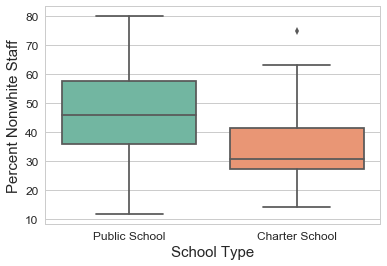

In [497]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=boston_15, palette="Set2")
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

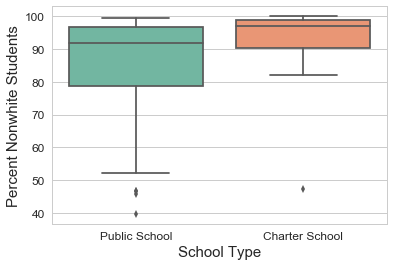

In [499]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Students", data=boston_15, palette="Set2")
sl.set_ylabel('Percent Nonwhite Students', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

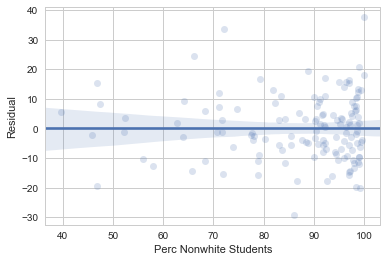

In [492]:
re = sns.regplot(x = boston_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});